<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/321_balance-prior-post.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(prior-influence-notebook)=
# L'influenza della distribuzione a priori

La notazione $p(\theta \mid y) \propto p(\theta) \ p(y \mid \theta)$ è particolarmente utile poiché evidenzia il fatto che la distribuzione a posteriori è una combinazione della distribuzione a priori e della verosimiglianza. Questo "mescolamento" delle due distribuzioni ci permette di integrare le informazioni a priori con quelle contenute nei dati osservati, ottenendo una stima più accurata della distribuzione di probabilità a posteriori del parametro $\theta$. 

In questo capitolo esamineremo alcuni esempi che aiutano a comprendere meglio come avviene questo processo di integrazione delle informazioni a priori e dei dati osservati. Considereremo qui un esempio discusso da {cite:t}`Johnson2022bayesrules`.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pyreadr
import requests
import seaborn as sns

from scipy import integrate, stats

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

Per la discussione successiva, useremo le seguenti funzioni per visualizzare la distribuzione a priori, la verosimiglianza e la distribuzione a posteriori nel caso beta-binomiale.

In [3]:
def plot_beta_binomial(
    alpha, beta, y=None, n=None, prior=True, likelihood=True, posterior=True
) -> None:
    """Plot a Beta-Binomial Bayesian Model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y observed number of successes
    @param n observed number of trials
    @param prior a logical value indicating whether the prior model should be plotted
    @param likelihood a logical value indicating whether the scaled likelihood should be plotted
    @param posterior a logical value indicating whether posterior model should be plotted
    """

    if y is None or n is None:
        print("Warning: to visualize the posterior specify function parameters y and n")

    θ = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(θ, alpha, beta)
    plt.fill_between(θ, p_theta_given_y, lw=4, color="k", label="prior", alpha=0.2)
    alpha_post = alpha + y
    beta_post = beta + n - y
    p_theta_given_y_post = stats.beta.pdf(θ, alpha_post, beta_post)
    plt.fill_between(θ, p_theta_given_y_post, lw=4, color="r", label="posterior", alpha=0.2)
    likelihood = stats.binom.pmf(y, n, θ)
    scale_factor = integrate.simpson(likelihood, θ)
    plt.fill_between(
        θ, likelihood / scale_factor, lw=4, color="b", label="likelihood scaled", alpha=0.2
    )
    plt.xlabel(r"$\pi$")
    plt.ylabel("density")
    plt.legend()


def summarize_beta_binomial(alpha, beta, y=None, n=None):
    """Summarize a Beta-Binomial Bayesian model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y number of successes
    @param n number of trials

    Return: Pandas dataframe summarizing beta binomial
    """

    def beta_mean(a, b):
        return a / (a + b)

    def beta_mode(a, b):
        if a < 1 and b < 1:
            return "0 and 1"
        elif a <= 1 and b > 1:
            return 0
        elif a > 1 and b < 1:
            return 1
        else:
            return (a - 1) / (a + b - 2)

    def beta_var(a, b):
        return a * b / ((a + b) ** 2 * (a + b + 1))

    prior_mean = beta_mean(alpha, beta)
    prior_mode = beta_mode(alpha, beta)
    prior_var = beta_var(alpha, beta)
    prior_sd = np.sqrt(prior_var)
    if y is None and n is None:
        summary = pd.DataFrame(
            {
                "alpha": alpha,
                "beta": beta,
                "mean": prior_mean,
                "mode": prior_mode,
                "var": prior_var,
                "sd": prior_sd,
            },
            index=["prior"],
        )
    else:
        post_alpha = y + alpha
        post_beta = n - y + beta
        post_mean = beta_mean(post_alpha, post_beta)
        post_mode = beta_mode(post_alpha, post_beta)
        post_var = beta_var(post_alpha, post_beta)
        post_sd = np.sqrt(post_var)
        summary = pd.DataFrame(
            {
                "alpha": [alpha, post_alpha],
                "beta": [beta, post_beta],
                "mean": [prior_mean, post_mean],
                "mode": [prior_mode, post_mode],
                "var": [prior_var, post_var],
                "sd": [prior_sd, post_sd],
            },
            index=["prior", "posterior"],
        )
    return summary

Se abbiamo a disposizione un campione di dati molto piccolo, ad esempio 15 successi su 20 prove nel caso di una distribuzione beta-binomiale, la distribuzione a priori può influenzare notevolmente la distribuzione a posteriori. Nel caso di una distribuzione a priori uniforme, invece, la distribuzione a posteriori sarà simile alla funzione di verosimiglianza, con l'eccezione dell'area sottesa sotto le due curve. In altre parole, per una distribuzione a priori uniforme, la distribuzione a posteriori avrà un picco nella stima di massima verosimiglianza, mentre per distribuzioni a priori diverse, la distribuzione a posteriori può essere significativamente diversa.

Iniziamo a considera il caso di una distribuzione a priori uniforme.

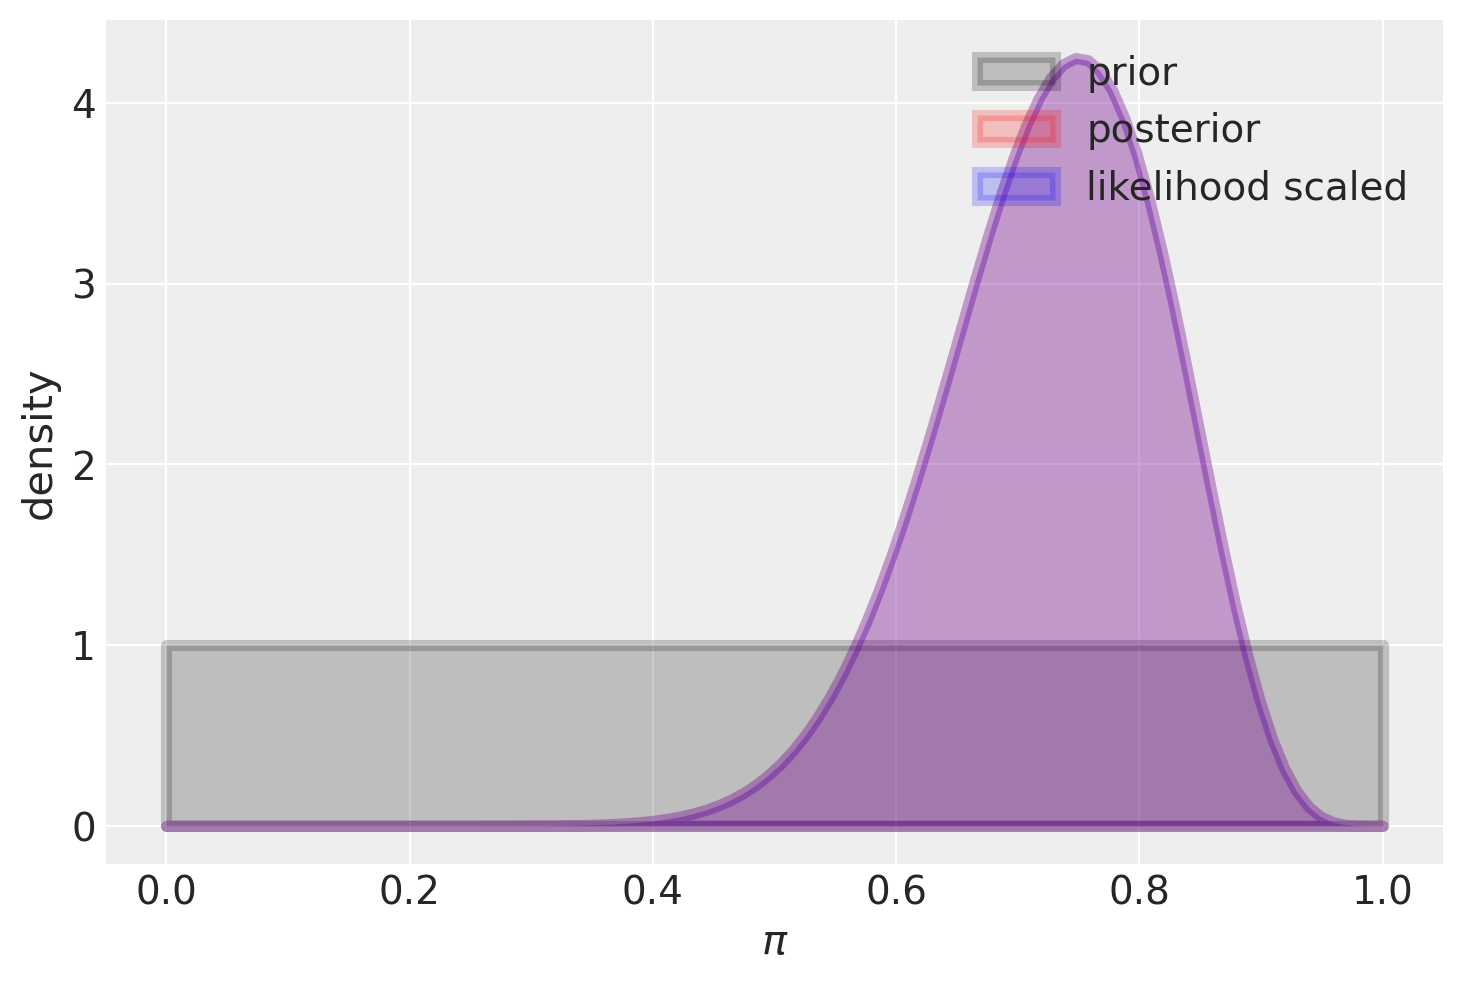

In [4]:
plot_beta_binomial(alpha=1, beta=1, y=15, n=20)

Consideriamo ora una distribuzione a priori poco informativa, come ad esempio una Beta(2, 2). In questo caso l'impatto di questa scelta sulla distribuzione a posteriori è modesto, ma comunque presente. Questo fenomeno può essere visto come un effetto di "regolarizzazione", il quale ci conduce a una stima più cauta rispetto a quella ottenuta tramite il principio di massima verosimiglianza. In altre parole, la stima risultante è maggiormente "spostata" verso il valore intermedio di 0.5.

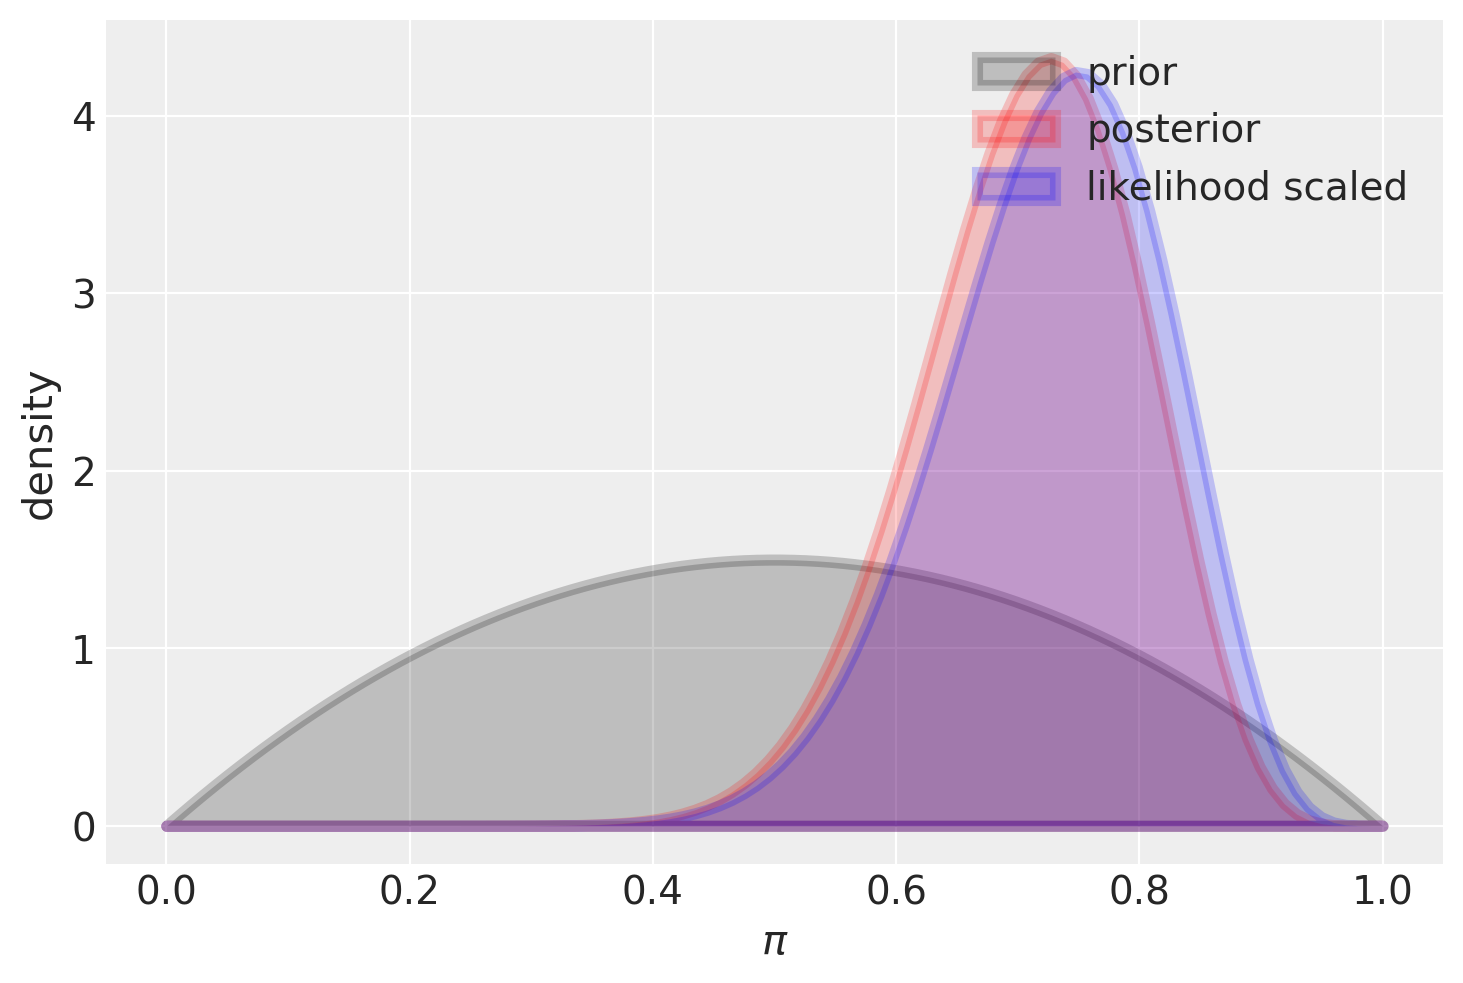

In [5]:
plot_beta_binomial(alpha=2, beta=2, y=15, n=20)

In [6]:
summarize_beta_binomial(alpha=2, beta=2, y=15, n=20)

,alpha,beta,mean,mode,var,sd
prior,2,2,0.500000,0.500000,0.050000,0.223607
posterior,17,7,0.708333,0.727273,0.008264,0.090906


Se il campione è più grande, l'utilizzo di una distribuzione a priori Beta(2, 2) ha un impatto trascurabile: infatti, il valore massimo della distribuzione a posteriori risulta quasi identico alla stima di massima verosimiglianza.

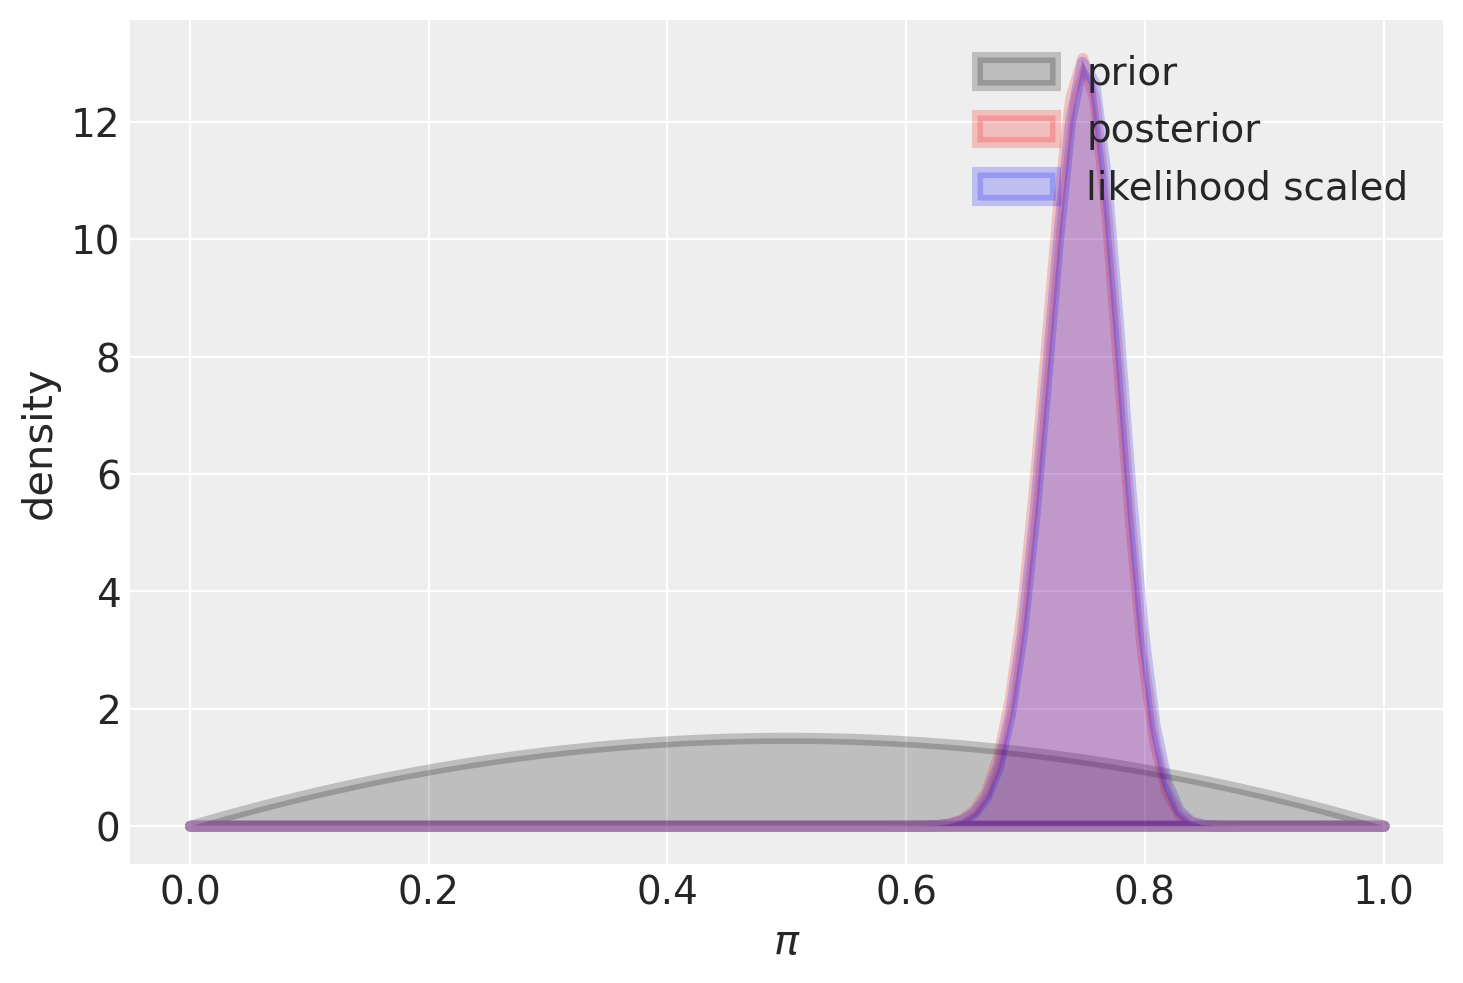

In [7]:
plot_beta_binomial(alpha=2, beta=2, y=150, n=200)

In [11]:
summarize_beta_binomial(alpha=2, beta=2, y=150, n=200)

,alpha,beta,mean,mode,var,sd
prior,2,2,0.500000,0.500000,0.050000,0.223607
posterior,152,52,0.745098,0.747525,0.000926,0.030438


Se usiamo una distribuzione a priori informativa, questa avrà un grande impatto sulla distribuzione a posteriori nel caso di un piccolo campione.

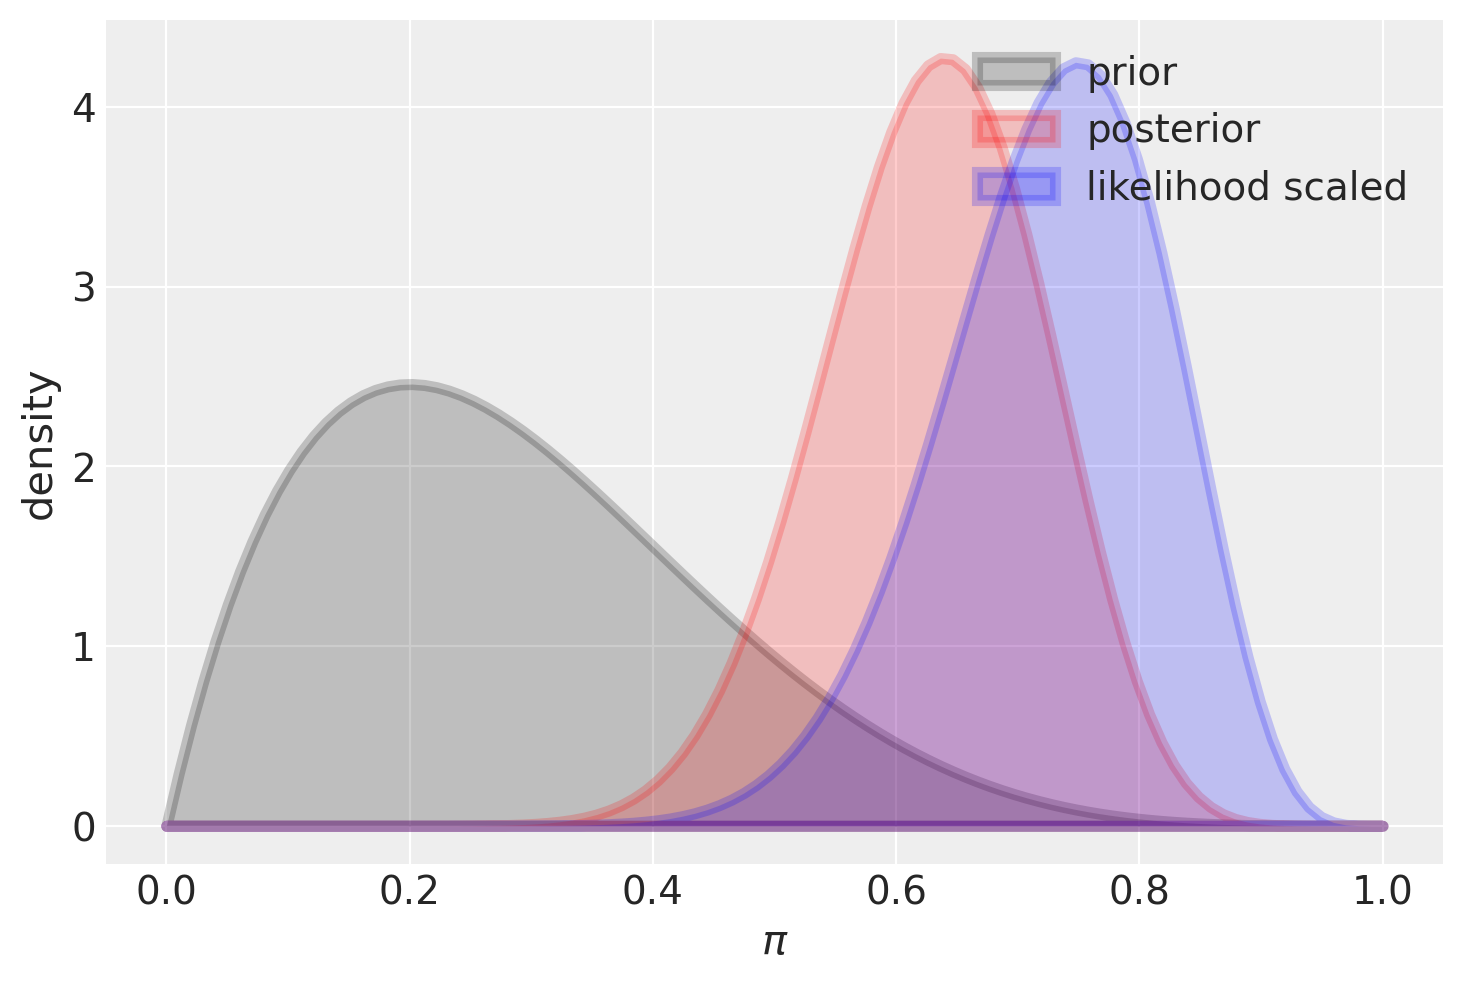

In [8]:
plot_beta_binomial(alpha=2, beta=5, y=15, n=20)

In [12]:
summarize_beta_binomial(alpha=2, beta=5, y=15, n=20)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.20,0.025510,0.159719
posterior,17,10,0.629630,0.64,0.008328,0.091260


Invece, la stessa distribuzione a priori ha un effetto trascurabile sulla distriuzione a posteriori se il campione è grande.

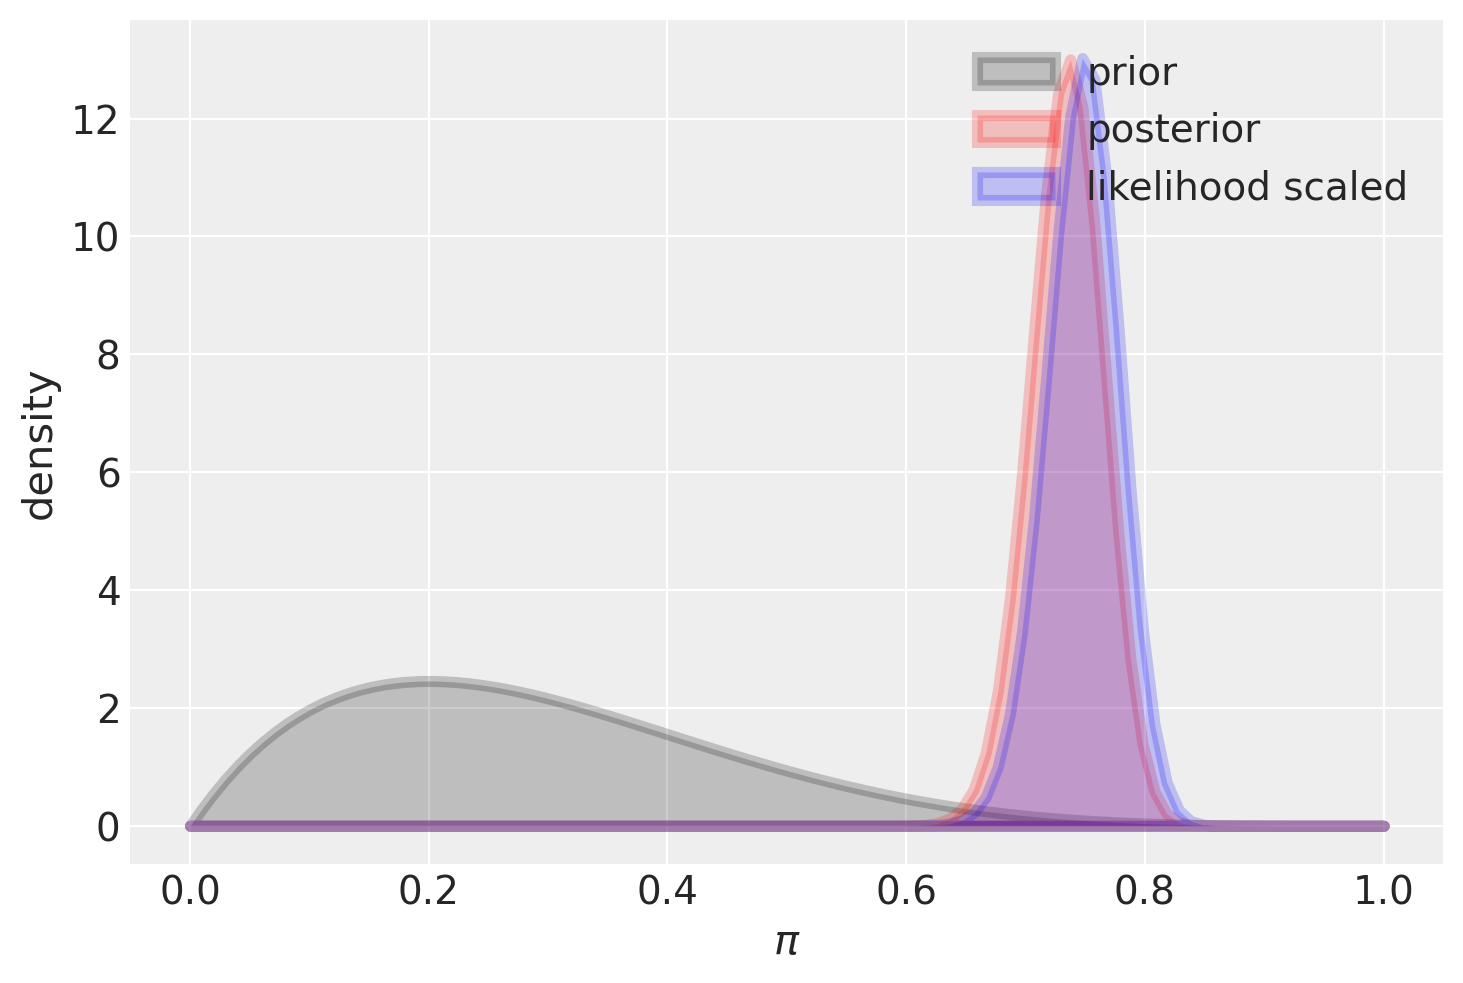

In [9]:
plot_beta_binomial(alpha=2, beta=5, y=150, n=200)

In [13]:
summarize_beta_binomial(alpha=2, beta=5, y=150, n=200)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.200000,0.025510,0.159719
posterior,152,55,0.734300,0.736585,0.000938,0.030627


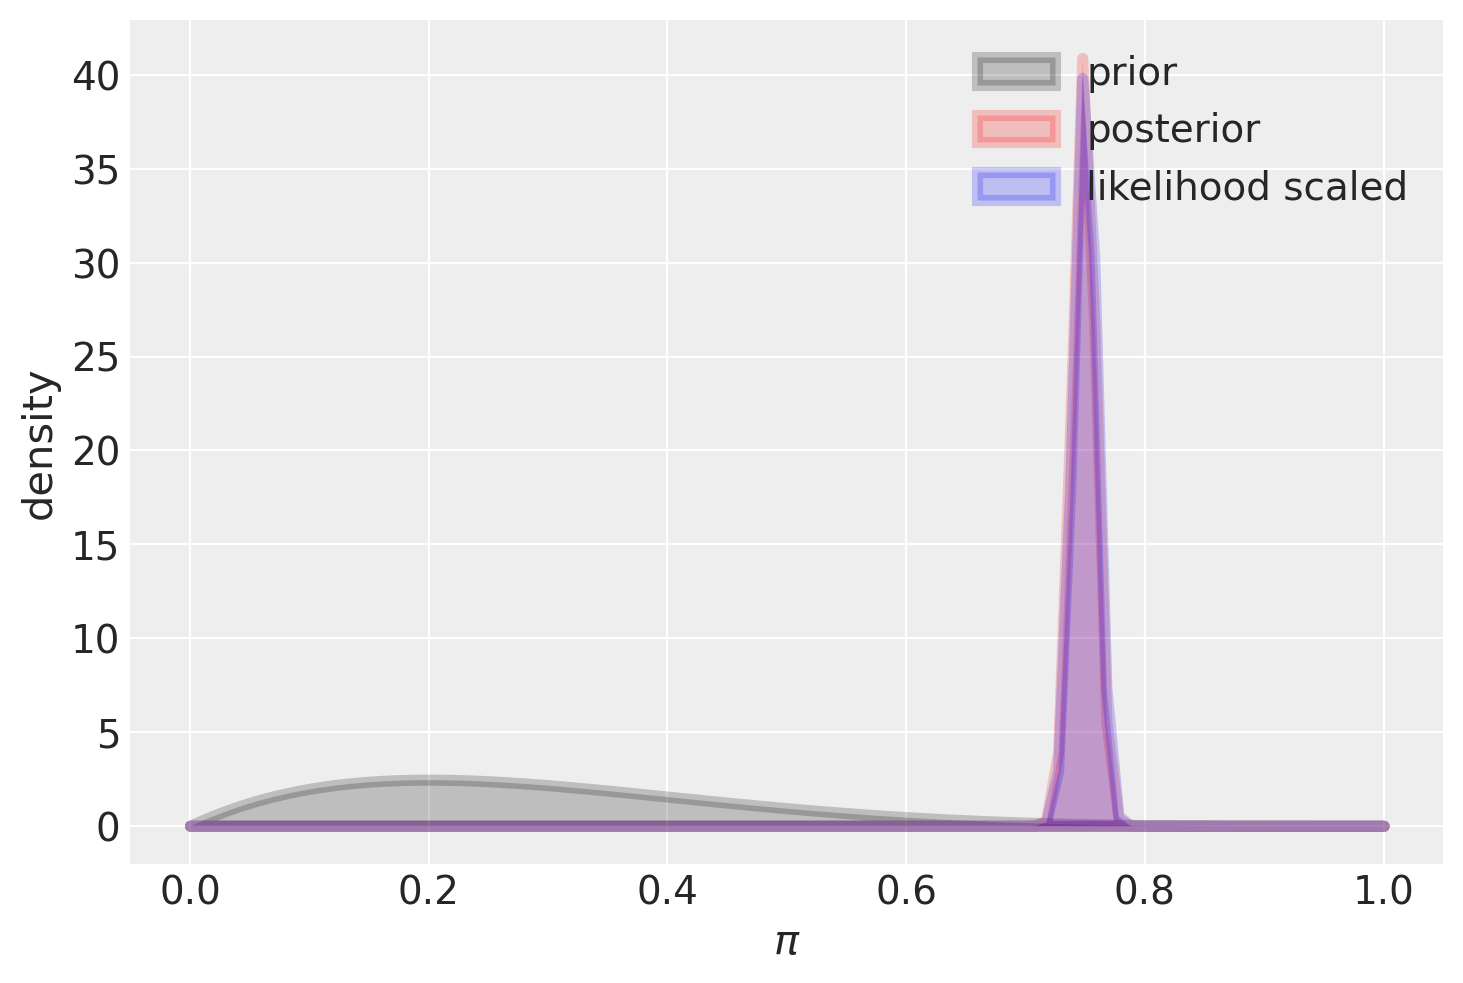

In [10]:
plot_beta_binomial(alpha=2, beta=5, y=1500, n=2000)

In [15]:
summarize_beta_binomial(alpha=2, beta=5, y=1500, n=2000)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.200000,0.025510,0.159719
posterior,1502,505,0.748381,0.748628,0.000094,0.009684


## Collegare le intuizioni alla teoria

Il bilanciamento tra la distribuzione a priori e le evidenze dei dati, come abbiamo visto negli esempi precedenti, non solo rispecchia le nostre intuizioni ma anche una necessità matematica. Questo è evidente dalla formula del valore atteso della distribuzione a posteriori nel caso beta-binomiale, che può essere riscritta come segue:

$$
\begin{align}
\mathbb{E}_{\text{post}} &[\text{Beta}(\alpha + y, \beta + n - y)] = \frac{\alpha + y}{\alpha + \beta +n}\notag\\ 
&= \frac{a+b}{a+b+n} \cdot \frac{a}{a+b} + \frac{n}{a+b+n} \cdot \frac{y}{n}.
\end{align}
$$ 

L'eq. {eq}`eq-ev-post-beta-bin` mostra che il valore atteso a posteriori è una media pesata tra il valore atteso a priori $\left( \frac{\alpha}{\alpha+\beta}\right)$ e la proporzione osservata di successi $\left(\frac{y}{n}\right)$. I pesi sono $\left( \frac{\alpha+\beta}{\alpha+\beta+n}\right)$ e $\left( \frac{n}{\alpha+\beta+n}\right)$. Pertanto, quando il numero di osservazioni $n$ è grande rispetto alla somma dei parametri $\alpha + \beta$, la distribuzione a posteriori dipenderà principalmente dai dati osservati e meno dalle credenze a priori. Al contrario, quando $n$ è piccolo rispetto a $\alpha + \beta$, i dati avranno una minore influenza rispetto alla credenza a priori.

Queste osservazioni ci indicano come scegliere i parametri $\alpha$ e $\beta$: se vogliamo assumere una totale ignoranza rispetto al fenomeno in esame, la scelta coerente è $\alpha = \beta = 1$ (ogni valore di $\theta$ è ugualmente credibile). Se, invece, abbiamo delle forti credenze a priori, possiamo scegliere $\alpha$ in modo che sia uguale al valore atteso a priori, mentre $\alpha + \beta$ esprime l'importanza che diamo all'informazione a priori: maggiore è il valore di $\alpha + \beta$, più dati saranno necessari per allontanare la distribuzione a posteriori dalla distribuzione a priori. Infine, se $n$ è grande, la distribuzione a posteriori avrà una scarsa influenza sulla distribuzione a priori, a meno di scelte estreme dei parametri a priori.

## Commenti e considerazioni finali 

Possiamo trarre una conclusione molto chiara dall'esempio discusso in {cite:t}`Johnson2022bayesrules`: l'aggiornamento bayesiano è simile ai processi di ragionamento del senso comune. Quando le nuove evidenze sono deboli, non c'è motivo di cambiare le nostre credenze pregresse, mentre quando le nuove evidenze sono irrefutabili, dobbiamo modificare le nostre credenze in modo da rispecchiare ciò che ci dicono i dati, indipendentemente dalle nostre credenze preesistenti. Questo approccio quantitativo e preciso esprime in termini matematici ciò che le nostre intuizioni ci suggeriscono.

Ciò che è sorprendente è che l'approccio frequentista nega questa logica. I test frequentisti non considerano le conoscenze pregresse e, pertanto, se un test frequentista, basato su un piccolo campione di dati, suggerisce di modificare le nostre credenze, questo viene preso sul serio, indipendentemente dalle evidenze pregresse che potrebbero dimostrare il contrario. Questo modo di pensare è in netto contrasto con l'approccio bayesiano, il quale utilizza tutte le informazioni a nostra disposizione per aggiornare le nostre credenze.

Questa discussione è ben riassunta nella celebre [striscia comica](https://xkcd.com/1132/).

## Watermark


In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w